In [ ]:
 import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install -q keras

# Cats and Dogs transfer learning

## Data preparation

Download and unzip the cats and dogs dataset.

In [ ]:
%%capture
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip
!mv PetImages train
!find train/Cat -size  0 -print0 |xargs -0 rm --
!find train/Dog -size  0 -print0 |xargs -0 rm --

Split some data for testing and validation.

In [ ]:
from glob import glob
from sklearn.model_selection import train_test_split

cats = glob('train/Cat/*.jpg')
dogs = glob('train/Dog/*.jpg')

cats_train, cats_test = train_test_split(cats, test_size=0.30)
dogs_train, dogs_test = train_test_split(dogs, test_size=0.30)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

!mkdir test

!mkdir test/Cat
files = ' '.join(cats_test)
!mv -t test/Cat $files

!mkdir test/Dog
files = ' '.join(dogs_test)
!mv -t test/Dog $files

Plot some random images from the dataset.

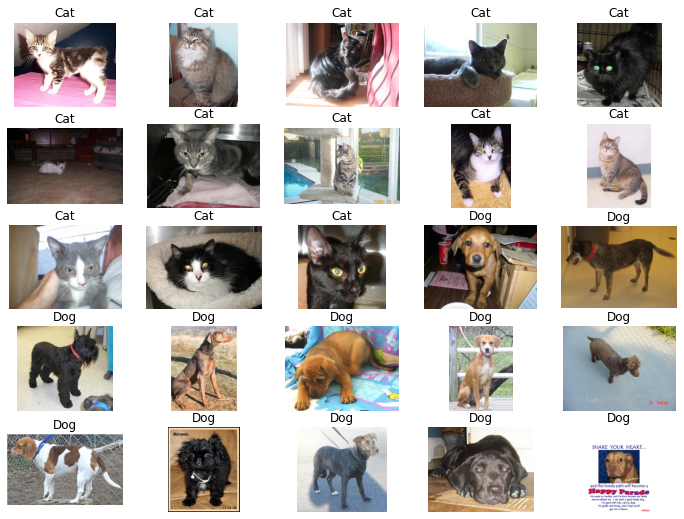

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

cats = np.random.choice(cats_train, 13)
dogs = np.random.choice(dogs_train, 12)
data = np.concatenate((cats, dogs))
labels = 13 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

## Model customization

In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


87916544/87910968 [==============================] - 8s 0us/step


## Data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 17498 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


Plot some images result of data augmentation.

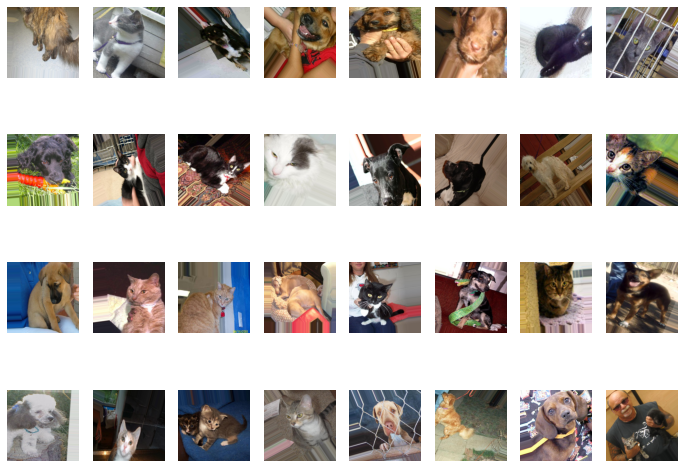

In [ ]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 279s 871ms/step - loss: 0.2342 - accuracy: 0.9024 - val_loss: 0.2265 - val_accuracy: 0.9683
Epoch 2/5
 40/320 [==>...........................] - ETA: 3:04 - loss: 0.1649 - accuracy: 0.9344

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

320/320 [==============================] - 267s 835ms/step - loss: 0.1648 - accuracy: 0.9338 - val_loss: 0.1853 - val_accuracy: 0.8994
Epoch 3/5
320/320 [==============================] - 267s 835ms/step - loss: 0.1435 - accuracy: 0.9443 - val_loss: 0.0082 - val_accuracy: 0.9688
Epoch 4/5
320/320 [==============================] - 267s 834ms/step - loss: 0.1410 - accuracy: 0.9451 - val_loss: 0.2658 - val_accuracy: 0.9186
Epoch 5/5
320/320 [==============================] - 267s 834ms/step - loss: 0.1451 - accuracy: 0.9438 - val_loss: 0.0021 - val_accuracy: 0.9785


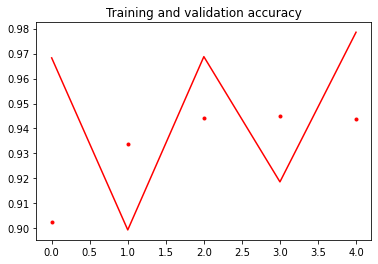

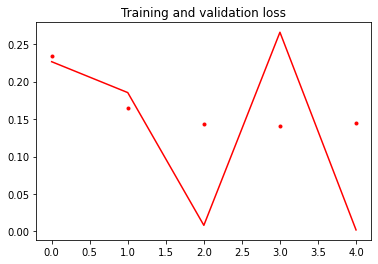

In [ ]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

## Prediction of the custom model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    """Run model prediction on image
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("cat", "dog")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

In [ ]:
model = load_model(MODEL_FILE)

array([8.8095934e-05, 9.9991190e-01], dtype=float32)

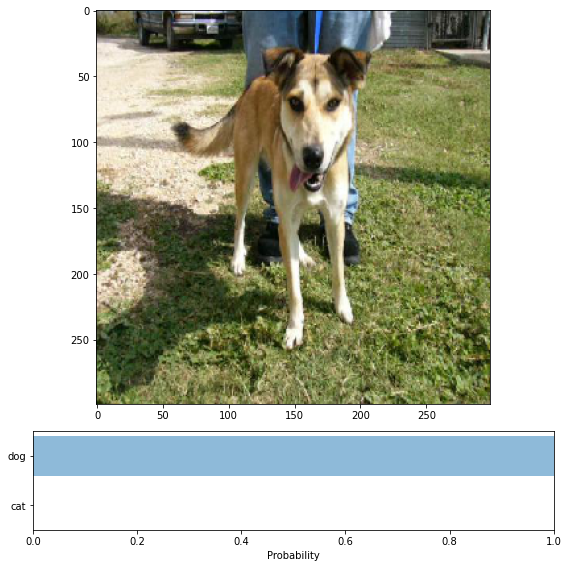

In [ ]:
img = image.load_img('test/Dog/151.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)

plot_preds(np.asarray(img), preds)
preds